# 1. Goals
In this notebook I'll attempt to build models to correctly predict the topic of the article. The techniques I'll use will include `Tf-idf` and `BOW` Analysis for feature-extraction, and `Unsupervised Learning` (Sklearn library) for clustering.

# 2. Introduction to DataSet
**From:** [snapcrack/all-the-news](https://www.kaggle.com/snapcrack/all-the-news)

This dataset contains news articles scraped from various publications, labeled by publication and author name, as well as date and title.
The original source on [kaggle.com](https://www.kaggle.com) contains three `.csv` files. Accross the three, there are over 140,000 articles from a total of 15 publications.

# Step: Import libraries

In [1]:
import os
# --------- Data processing --------- #
import pandas as pd
import numpy as np
from itertools import islice
# --------- Gensim --------- #
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore, CoherenceModel
from gensim.models.wrappers import LdaMallet
# --------- Visualization --------- #
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
import plotly.express as px

# Step: Read & show data

In [2]:
datasets_path = [
    'data/articles1.csv',
    'data/articles2.csv',
]
dataframes = []
for file in datasets_path:
    df = pd.read_csv(file)
    df = df['content']
    dataframes.append(df)
news = pd.concat(dataframes, ignore_index=True)

In [3]:
news.describe()

count             99999
unique            99488
top       advertisement
freq                 42
Name: content, dtype: object

In [4]:
print('number of nan value: ', news.isna().sum())
print('\nHead of data:\n',news.head())
print('\nTail of data:\n',news.tail())

number of nan value:  0

Head of data:
 0    WASHINGTON  —   Congressional Republicans have...
1    After the bullet shells get counted, the blood...
2    When Walt Disney’s “Bambi” opened in 1942, cri...
3    Death may be the great equalizer, but it isn’t...
4    SEOUL, South Korea  —   North Korea’s leader, ...
Name: content, dtype: object

Tail of data:
 99994    There have been many proposed solutions to the...
99995    Maybe I feel like August won’t let go of me, b...
99996    Diana Marcela, 28, has spent 13 years with Far...
99997    This Christmas break, for anybody steeped in t...
99998    Brian Nesbitt’s therapist made a suggestion in...
Name: content, dtype: object


# Step: pre-process data

I use various libraries to perform this cleaning

- Remove extra items from the text (e.g mail address, numbers, whitespace)
- Tokenize text (Each text a list and each word a index of this list)
- Make bigram words (A word for two words that are often repeated)
- extract part-of-speech and useful part

In [5]:
def simple_preprocess(row: str) -> list:
    import re
    from textblob import Word
    from string import punctuation
    from nltk import word_tokenize
    from nltk.stem.snowball import SnowballStemmer
    from gensim.parsing.preprocessing import STOPWORDS
    
    
    publication = {'breitbart','cnn','talking','points',
                   'guardian','york','national','new',
                   'business','fox','review','insider',
                   'memo','times','buzzfeed',
                   'post','news','atlantic'}
    STOPWORDS = STOPWORDS | publication
    #Mail address
    row = re.sub('(\S+@\S+)(com|\s+com)', ' ', row)
    #Username
    row = re.sub('(\S+@\S+)', ' ', row)
    #punctuation and lowercase
    punctuation = str(punctuation 
                      + '\n'
                      + '—“,”‘-’'
                      + '0123456789')
    row = ''.join(word.lower() for word in row 
                  if word not in punctuation)
    #Extra whitespace
    row = re.sub('\s{1,}', ' ', row)
    #tokenize
    row = word_tokenize(row)
    #Stopwords and Lemma
    row = [Word(word).lemmatize() for word in row 
           if word not in STOPWORDS and 
           len(word) > 2]
    #Stemming
    #stemmer = SnowballStemmer(language='english')
    #row = [stemmer.stem(word) for word in row]
    
    return row

def make_ngram(data: list,
               be_trigram:bool = False) -> list:
    from gensim.models import Phrases
    from gensim.models.phrases import Phraser

    bigram = Phrases(data, min_count=10, threshold=20)
    bigram_mod = Phraser(bigram)
    sentences = [bigram_mod[row] for row in data]
    
    if be_trigram:
        trigram = Phrases(sentences, min_count=8, threshold=50)
        trigram_mod = Phraser(trigram)
        sentences = [trigram_mod[row] for row in sentences]
    
    return sentences

def pos_determine(row, tags = ['N', 'J', 'V']):
    from nltk import pos_tag
    row = [word for (word, pos) in pos_tag(row)
          if pos[0] in tags]
    
    return row

def finalize_preprocess(data):
    sentences = []
    for row in data:
        text_processed = simple_preprocess(row)
        text_processed = pos_determine(text_processed, tags=['N'])
        sentences.append(text_processed)
    sentences = make_ngram(sentences, be_trigram=True)
    
    return sentences

In [6]:
%%time
data = news.values.tolist()
sentences = finalize_preprocess(data)
print('cleaned text:\n', sentences[12][0:80])

cleaned text:
 ['palm_beach_fla', 'donald_trump', 'year', 'weekend', 'opulence', 'actor', 'sylvester_stallone', 'gossip', 'page', 'fixture', 'fabio', 'crowd', 'developer', 'trump', 'resort_palm_beach', 'president', 'george_bush', 'ranch_crawford', 'kennebunkport', 'president', 'vacation_hawaii', 'home', 'trump', 'club', 'florida', 'week', 'home', 'city', 'eclipse', 'president', 'winter', 'house', 'intention', 'cereal', 'property', 'owner', 'government', 'serve', 'home', 'president', 'government', 'plan', 'property', 'club', 'membership', 'cost', 'figure', 'trump', 'arrival', 'palm_beach', 'elite', 'membership', 'jew', 'establishment', 'club', 'owner', 'island', 'admit', 'trump', 'victory', 'november', 'amenity', 'unique', 'club', 'chance', 'rub', 'president', 'disneyland', 'mouse', 'day', 'greene', 'developer', 'candidate', 'senate', 'florida', 'member', 'clinton', 'supporter', 'executive', 'cabinet']
Wall time: 46min


In [7]:
dictionary = Dictionary(documents=sentences)

# add all of cleared text in a Series for easy save (.csv)
series = pd.Series((','.join(row) for row in sentences))
# store the dictionary and pre-processed, for future reference
series.to_csv('data/clean_news_Noun.csv', index=False)
dictionary.save('data/news_Noun.dict')

In [10]:
# Load pre-processed words
data = pd.read_csv('data/clean_news_Noun.csv',
                   header=0,
                   names=['clean_content'])
data = data['clean_content']
data.dropna(inplace=True)
sentences = [row.split(',') for row in data]

# Load dictionary
dictionary = Dictionary.load('data/news_Noun.dict')
# Checking dictionary loaded
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

0 access
1 administration
2 ally
3 appeal
4 appropriation
5 approval


### removes all tokens in the dictionary that are:
- Less frequent than 5 documents
- More frequent than 40% documents( Stopword if exist )
- Keep only the first 150_000 most frequent tokens.

In [11]:
print('len dictionary before filtering: ',len(dictionary))
dictionary.filter_extremes(no_below=5, no_above=0.40, keep_n=150_000)
print('len dictionary after filtering: ',len(dictionary))
# dictionary from words and frequency
word2freq = {dictionary[id_]: freq 
             for id_, freq in dictionary.cfs.items()}
#sort words frequency
word2freq = dict(sorted(word2freq.items(),
                        key=lambda item: item[1],
                        reverse=True))

len dictionary before filtering:  203808
len dictionary after filtering:  63133


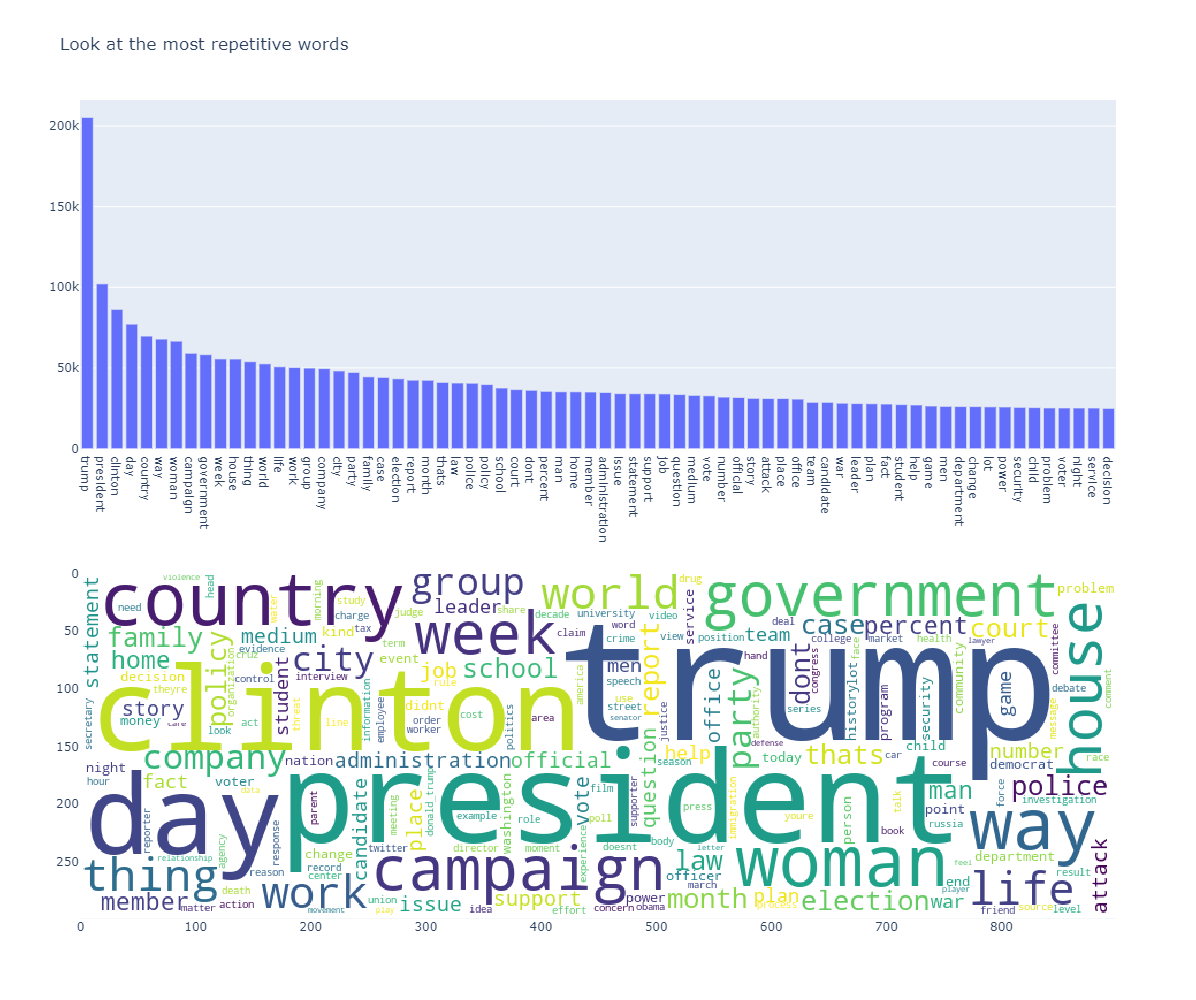

In [4]:
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "bar"}], [{"type": "image"}]],
)

most_freq = dict(islice(word2freq.items(), 70))
X_axis = list(most_freq.keys())
y_axis = list(most_freq.values())

fig.add_trace(go.Bar(x=X_axis, y=y_axis),
              row=1, col=1)

wordcloud = WordCloud(width=900,
                      height=300,
                      background_color='white',)
cloud = wordcloud.generate_from_frequencies(word2freq)

fig.add_trace(px.imshow(cloud).data[0],
              row=2, col=1)

fig.update_layout(height=1000,
                  width=1200,
                  title_text="Look at the most repetitive words",)
fig.show()

# Step: feature extraction

in topic modeling `tf-idf` have better performance

In [12]:
# Create the Bag-of-words model for each document
bow_corpus = [dictionary.doc2bow(doc) for doc in sentences]
# Create tf-idf model for each document
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# Preview BOW, tf-idf for our sample preprocessed document
document_n = 180
bow_doc_x = bow_corpus[document_n]
tfidf_doc_x = tfidf_corpus[document_n]
for i in range(20):
    print(f'Word {bow_doc_x[i][0]} "{dictionary[bow_doc_x[i][0]]}"', end=' ')
    print(f'appears {bow_doc_x[i][1]} time. with {tfidf_doc_x[i][1]:.5f} frequency')

Word 68 "jan" appears 1 time. with 0.06368 frequency
Word 85 "month" appears 1 time. with 0.01977 frequency
Word 118 "sue" appears 1 time. with 0.07151 frequency
Word 246 "crime" appears 1 time. with 0.03899 frequency
Word 255 "day" appears 2 time. with 0.02876 frequency
Word 257 "death" appears 1 time. with 0.03287 frequency
Word 352 "hour" appears 1 time. with 0.03001 frequency
Word 393 "man" appears 1 time. with 0.02538 frequency
Word 445 "period" appears 1 time. with 0.04160 frequency
Word 550 "studio" appears 1 time. with 0.06149 frequency
Word 589 "video" appears 3 time. with 0.10852 frequency
Word 642 "career" appears 1 time. with 0.04029 frequency
Word 644 "character" appears 1 time. with 0.04614 frequency
Word 671 "director" appears 1 time. with 0.03289 frequency
Word 674 "documentary" appears 1 time. with 0.08416 frequency
Word 695 "film" appears 1 time. with 0.04578 frequency
Word 753 "march" appears 1 time. with 0.03725 frequency
Word 807 "shop" appears 1 time. with 0.06020

# Step: Create model
## Latent Dirichlet Allocation

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

* Reference: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

## __Note:__ Select best number of topic for model
calculate Coherence and use the best score 
### What is Coherence?
<br>
read below article to understand background of coherence:

__Link__ : https://rare-technologies.com/what-is-topic-coherence/

In [5]:
def coherence_n_topics(
    id2word, corpus, texts,
    number_of_topics: list
):
    #update this two path in your local mallet path
    os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
    mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'
    
    coherence_acc = []
    model_difference_topic = []
    
    for num_topics in number_of_topics:
        model = LdaMallet(
            mallet_path,
            corpus=corpus,
            num_topics=num_topics,
            id2word=id2word,
        )
        
        model_difference_topic.append(model)
        
        coherencemodel = CoherenceModel(
            model=model, texts=texts,
            dictionary=id2word
        )
        
        coherence_acc.append(coherencemodel.get_coherence())

    return model_difference_topic, coherence_acc

C:\Users\omidforoqi\AppData\Roaming\Python\Python38\site-packages\gensim\models\wrappers\ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


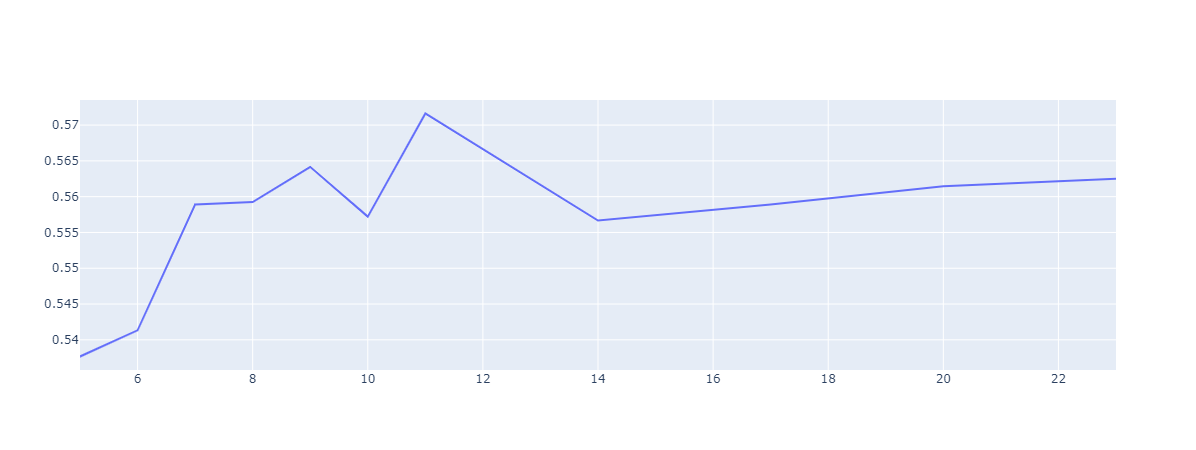

In [6]:
topic_n = list(range(5, 11)) + list(range(11, 25, 3))
models, coherence_accuracy = coherence_n_topics(
    dictionary, tfidf_corpus, sentences, topic_n
)
topic_n = np.array(topic_n)
best_topic_n = topic_n[np.argsort(coherence_accuracy)][-1]

fig = go.Figure(
    go.Scatter(
        x=topic_n,
        y=coherence_accuracy,
        mode='lines',
    )
)
fig.show()

In [7]:
%%time
lda_model = LdaMulticore(
    corpus=tfidf_corpus, num_topics=best_topic_n,
    id2word=dictionary, workers=3,
    chunksize=8000, passes=20,
    iterations=800,
)

coherence_model = CoherenceModel(
    model=lda_model, texts=sentences,
    dictionary=dictionary, coherence='c_v',
)
# save created model
lda_model.save('data/lda_model', ignore=('state', 'dispatcher'))
print('Coherence Score: ', coherence_model.get_coherence())

Coherence Score:  0.5801119348461744
Wall time: 36min 41s


In [13]:
#load lda model
lda_model = LdaMulticore.load('data/lda_model')

# Step: visualisation
after we build LDA model, need to visualize this for show better result. 
the easiest approch is to use `pyLDAvis` package, with less than a few line code we have a good visualisation.

In [ ]:
# import pyLDAvis
# from pyLDAvis.gensim import prepare


# vis = prepare(lda_model, tfidf_corpus, dictionary)
# pyLDAvis.show(vis, port=8889)

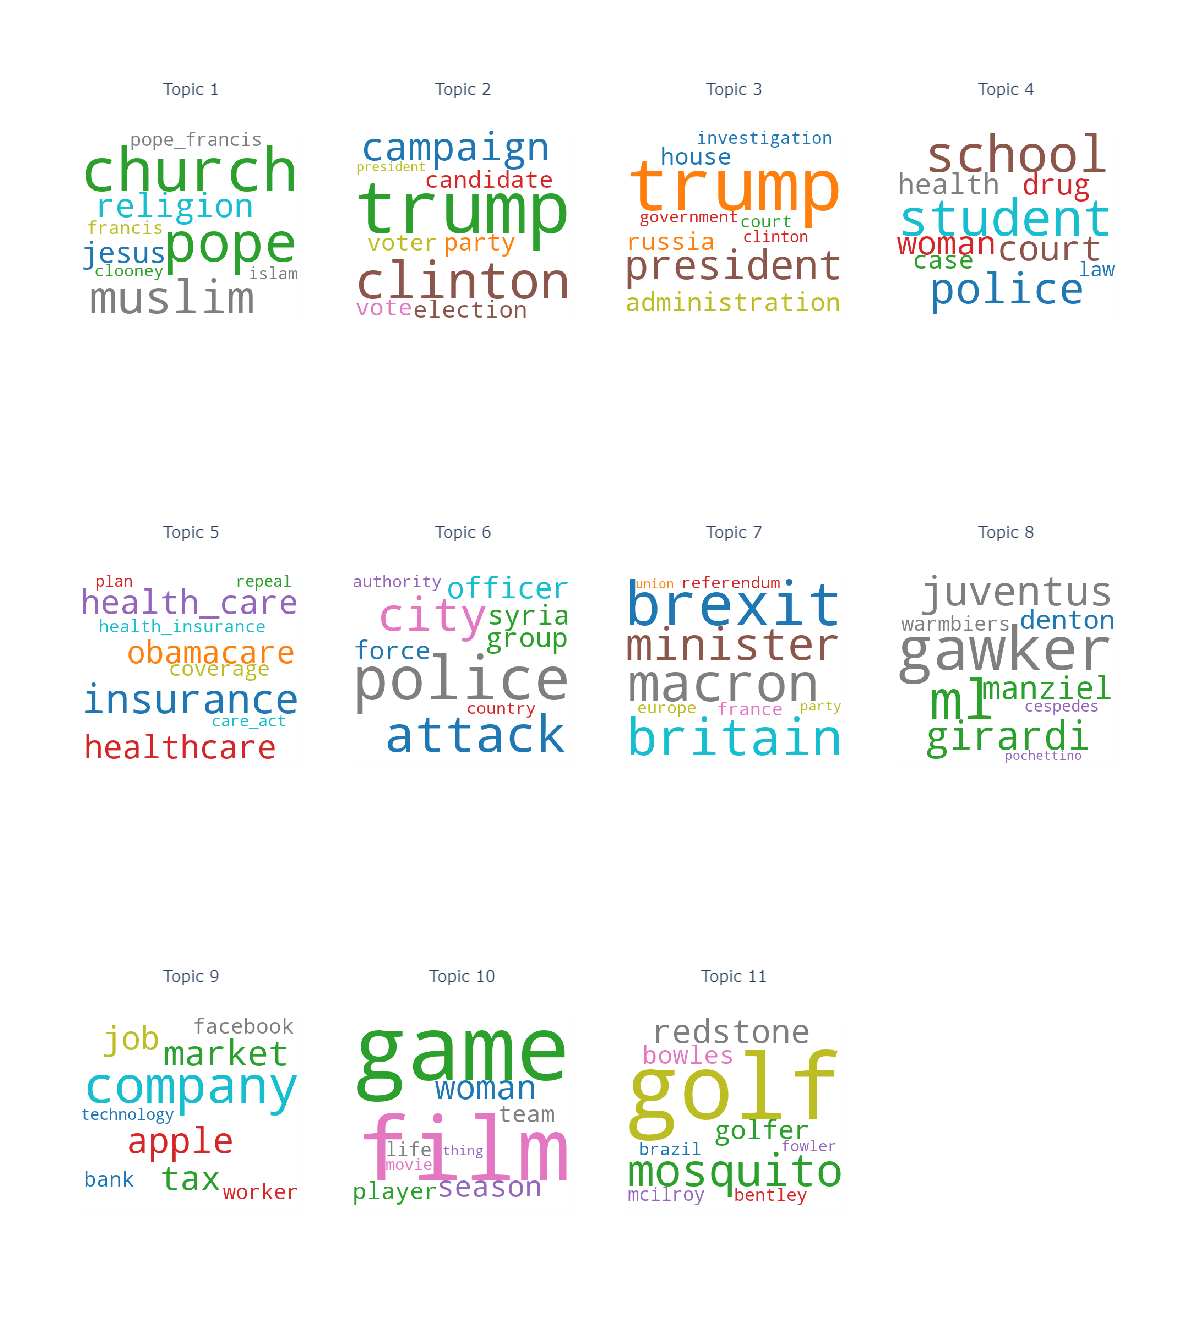

In [25]:
topics = lda_model.show_topics(
    num_topics=-1,
    num_words=9,
    formatted=False,
)

cloud = WordCloud(background_color='white',
                  width=400,
                  height=350,
                  max_words=20,
                  colormap='tab10',
                  prefer_horizontal=1.0)

fig = make_subplots(3, 4,
                    subplot_titles=tuple(
                        f'Topic {n+1}' for n in range(best_topic_n)
                    ))
for n in range(best_topic_n):
    topic_words = dict(topics[n][1])
    cloud.generate_from_frequencies(topic_words,
                                    max_font_size=300)
    fig.add_trace(px.imshow(cloud).data[0],
                  row=int(n/4)+1, col=n%4+1)

fig.update_layout(height=120*best_topic_n, width=1200,
                  coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

# Topics:
1. Religion
2. Presidential election
3. U.S president
4. Society
5. Health
6. War
7. Europe
8. Other
9. Technology & Marketing
10. Entertainment
11. Golf

# Step: Test
test model with two unseen news 

In [40]:
# True topic of this news is 9
quiz = """Cristiano Ronaldo is 'the best finisher of all time',
according to former Juventus teammate Andrea Barzagli.The Italian defender, 
who spent several months playing alongside the five-time Ballon d'Or winner
in Turin before retiring in 2019, has praised Portugal's all-time top goalscorer
for his hunger and 'wickedness' in front of goal. In an interview on Juventus' 
official Twitch account, Barzagli was full of praise for the 36-year-old forward.
He said: 'The striker who put me in most difficulty?
Ronaldo always scored against us so it was always very difficult with him.
Didier Drogba also, a force of nature.
'Ronaldo? He is the best finisher of all time.
He scores goals for you in all different ways. His goals record says it all.
His wickedness and his hunger are incredible things."""
quiz = finalize_preprocess([quiz])
quiz_bow = [dictionary.doc2bow(quiz[0])]
tfidf_doc_x = tfidf[quiz_bow][0]

lda_model[tfidf_doc_x]

[(0, 0.023953428),
 (1, 0.02395353),
 (2, 0.023955168),
 (3, 0.088387296),
 (4, 0.024108302),
 (5, 0.0239836),
 (6, 0.02395172),
 (7, 0.14177632),
 (8, 0.023953281),
 (9, 0.5780257),
 (10, 0.023951637)]

In [42]:
quiz = """
(CNN)Former President Donald Trump and attorney Rudy Giuliani 
are being accused of conspiring with the far-right groups 
Proud Boys and Oath Keepers to incite the January 6 insurrection
in a civil lawsuit filed Tuesday in federal court by the Democratic
chairman of the House Homeland Security Committee.
The suit cites a post-Civil War law designed to combat
violence and intimidation by the Ku Klux Klan.
The lawsuit, filed by Mississippi Democratic Rep.
Bennie Thompson in his personal capacity,
is the first civil action filed against the former President
related to the attack at the US Capitol
and comes days after the Senate acquitted Trump in his impeachment trial
"""
quiz = finalize_preprocess([quiz])
quiz_bow = [dictionary.doc2bow(quiz[0])]
tfidf_doc_x = tfidf[quiz_bow][0]

lda_model[tfidf_doc_x]

[(0, 0.017326793),
 (1, 0.01732889),
 (2, 0.6553235),
 (3, 0.18872662),
 (4, 0.017327033),
 (5, 0.017329752),
 (6, 0.017326916),
 (7, 0.017326815),
 (8, 0.017327737),
 (9, 0.017329127),
 (10, 0.017326783)]